100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:38<00:00, 79.25s/it]


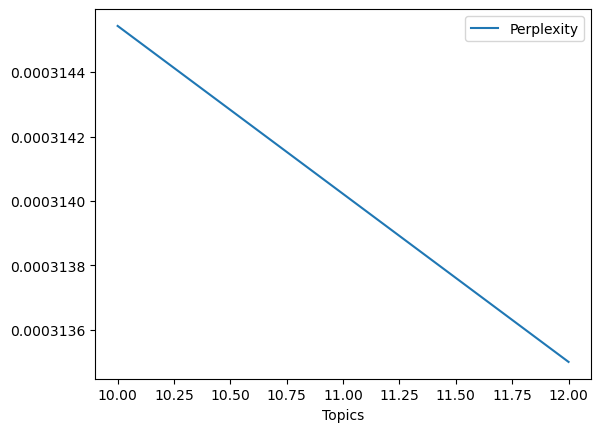

In [1]:

import pandas as pd

import numpy as np
np.random.seed(2018)
import gensim
from gensim import corpora

import ast
# We then load the cleaned dataset from google drive and load into a dataframe.

# In[14]:

trainingDf = pd.read_csv('data_cleaned_1.csv')


# Due to issues with data formatting from the preprocessing, the 'text' and 'combine' columns contain the same information, however the 'text' column contains a list of the string word tokens, whereas 'combine' contains a string for each document. Below we assign docs to be just the 'combine' column.

# In[15]:


def myprocess(thisdoc):
    ## Runs on documents (vector of words)
    return([text for text in thisdoc.split()])


# In[16]:

docs=([ast.literal_eval(text) for text in trainingDf['text']])

# Below we implement the concept of a dictionary, by mapping words to their integer ids. We then filter out any tokens (words) which have frequency less than 5. The no_above parameter removes tokens appearing in more than 50% of documents will be removed. This is because words appearing in less than 5 documents will not help form topics, nor will words that occur very frequently (e.g. book).

# In[18]:


dict_LoS = corpora.Dictionary(docs)


# In[19]:


dict_LoS.filter_extremes(no_below=5, no_above=0.5)


# Below we inspect the local directory to try to find the pickle file in order to load it. If the pickle file does not exist there then we create the bag of words corpus for the first time and save this as a pickle. We chose to use pickle over CSV because using pickles was faster when compared to CSV files and has the ability to reduce the file size to almost half of CSV files using its compression techniques.

# In[20]:


# bag of words

bow_corpus = [dict_LoS.doc2bow(w) for w in docs]
#pickle.dump(bow_corpus, open('bow_corpus.pkl', 'wb'))
#pickle.dump(dict_LoS, open('dictionary.pkl', 'wb'))


# Here we perform a similar step, by checking whether the LDA model has already been created and saved as a pickle file. We chose the default number of topics to be 15, and instructed the model to pass over the entire corpus only once for time purposes. we chose to increase the size of the dataset we would train and tune on instead.

# In[22]:


# In[23]:




# # Evaluation of Initial Model

# Coherence and perplexity are two types of metrics which can be used to evaluate topic models. 
# Coherence represents how human interpretable the topics are, whereas perplexity represents how probable some new unseen data is given the model that was learned earlier. Ideally, we would like high coherence and low perplexity.
# 
# For coherence, we chose the C_v measure which is based on a sliding window, one-set segmentation of the top words and an indirect confirmation measure that uses normalized pointwise mutual information (NPMI) and the cosine similarity [[Evaluating LDA Topic Models](https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0#:~:text=But%20before%20that%E2%80%A6-,What%20is%20topic%20coherence%3F,are%20artifacts%20of%20statistical%20inference)].
# 
# 
# 


# In[25]:


# Compute Coherence Score function


# In[26]:

# In[27]:


import math


# In[28]:


# Compute perplexity score on the whole corpus

# ## Hyperparameter tuning

# Now we have established a baseline evaluation for our model, we can adjust the hyperparameters to try and optimise the perplexity score.
# 
# The key hyperparameters for our LDA model are:
# 
# * Number of Topics (K)
# * Dirichlet hyperparameter alpha: Document-Topic Density
# * Dirichlet hyperparameter beta: Word-Topic Density
# 
# Number of topics
# Determining the number of topics for an LDA topic modelling alogirthm is important as too few topics may not capture the relationships well between the words, whereas too many topics may produce 'rubbish'. This is similar to under and overfitting respectively.
# 
# 
# Aside from the number of topics, the most important parameters are the Bayesian prior hyperparameters alpha and beta (labelled ‘eta’ in Gensim). Both hyperparameters represent our prior beliefs about the corpus before we train our model.
# 
# Due to time and resource constraints, we decided to only explore the number of topics hyperparameter.
# 
# To determine the number topics, we shall create our own grid search algorithm which iterates through each point in the search space and calculates the perplexity score. We are aiming to minimise our perplexity score, however, we will use the elbow method when plotting the number of topics (k) against the perplexity to select the optimal k. This will hopefully prevent our model from overfitting.

# In[29]:


# this is our supporting function for computing perplexity
def compute_perplexity_values(k):
    
    lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=k, id2word=dict_LoS, passes=2, workers=2)
    
    perplexity_model_lda = math.exp(lda_model.log_perplexity(bow_corpus))
    
    return perplexity_model_lda


# Here we include a progress bar so the user can see how long the grid search has left.

# In[30]:


import tqdm


# We iterate over a range of topic numbers, from 10 to 30, with step size 2. The next chunk of code may take a while to run and should ideally be ran on a HPC. The model results are then outputted to a dataframe and plotted. The plot is saved to an external file.

# In[38]:


min_topics=10
max_topics=12
step =2

topics_range = range(min_topics, max_topics+1, step)

model_results = {'Topics': [],
                 'Perplexity': []
                }

pbar = tqdm.tqdm(total=(len(topics_range)))
for k in topics_range:
    cp = compute_perplexity_values(k=k)
    model_results['Topics'].append(k)
    model_results['Perplexity'].append(cp)
    
    pbar.update(1)
pbar.close()
    
    
    


# This code was adapted from [Evaluating LDA Topic Models](https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0#:~:text=But%20before%20that%E2%80%A6-,What%20is%20topic%20coherence%3F,are%20artifacts%20of%20statistical%20inference).

# In[39]:


dframe = pd.DataFrame(model_results)


# In[42]:


fig = dframe.plot(x ='Topics', y='Perplexity', kind='line').get_figure()
fig.savefig('perplexity_plot.pdf')


# Lastly, the scores dataframe is saved to a csv.

# In[43]:


dframe.to_csv('perplexity_scores.csv', index=False)

